<h1>Regression</h1>

In [11]:
import csv
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

<h2>Laden der Daten</h2>

In [ ]:
df = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

In [2]:
df_wdi = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/WDI.HM-2.csv", parse_dates=["Date"])

<h2>Vorverarbeitung der Daten</h2>

In [3]:
#Berechnung der Returns für Log
df_wdi["returns"] = np.log(df_wdi.Close.pct_change() + 1)

In [4]:
#Berechnung der Lags
def lagit(df, lags):
    names = []
    for i in range(1, lags+1):
        df["Lag_"+str(i)] = df["returns"].shift(i)
        names.append("Lag_"+str(i))
    df.dropna(inplace=True)    
    return names, df

<h2>Lineare Regression mit Statsmodels</h2>

In [13]:
def regression(df, regressor, output):
    train, test = train_test_split(df, shuffle=False, test_size=0.3, random_state=0)
    
    train_x = train[regressor]
    train_y = train[output]
    
    test_x = test[regressor]
    test_y = test[output]
    
    train_x, train_y = np.array(train_x), np.array(train_y)
    test_x, test_y = np.array(test_x), np.array(test_y)
    
    train_x = sm.add_constant(train_x)
    test_x = sm.add_constant(test_x)
    
    model = sm.OLS(train_y, train_x).fit()
    
    predictions = model.predict(test_x)
    
    print_model = model.summary()
    
    #print(predictions)
    print(print_model)
    return model, predictions, test

<h2>Ausführung</h2>

In [14]:
lagnames, df_wdi = lagit(df_wdi, 5)
reg_model, reg_predictions, test = regression(df_wdi, lagnames, "returns")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.301
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           9.62e-06
Time:                        20:55:32   Log-Likelihood:                 1669.0
No. Observations:                 783   AIC:                            -3326.
Df Residuals:                     777   BIC:                            -3298.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1700      0.093     12.521      0.0

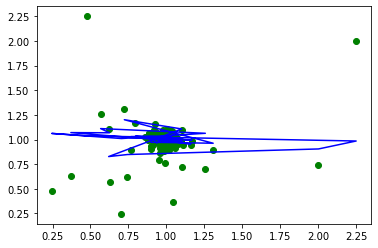

In [17]:
plt.scatter(test["Lag_1"], test["returns"], color="green")
plt.plot(test["Lag_1"], reg_predictions, color="blue")
plt.show()

In [20]:
reg_model, reg_predictions, test = regression(df_wdi, ["Lag_5"], "returns")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     14.82
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           0.000128
Time:                        21:02:29   Log-Likelihood:                 1660.8
No. Observations:                 783   AIC:                            -3318.
Df Residuals:                     781   BIC:                            -3308.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8605      0.037     23.419      0.0

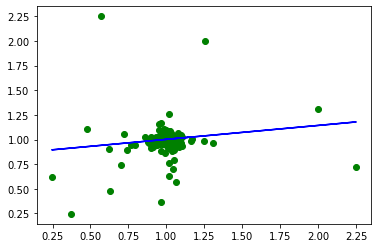

In [21]:
plt.scatter(test["Lag_5"], test["returns"], color="green")
plt.plot(test["Lag_5"], reg_predictions, color="blue")
plt.show()

<h2>Test</h2>